# 1. Imports

In [3]:
# scikit-learn
from sklearn import set_config # return pd.DataFrame from transformers
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, RobustScaler # scale to zero mean and unit variance
from sklearn.decomposition import PCA # primary component analysis
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

# others
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plots
import numpy as np
import pickle # move transformers and estimators between notebooks

# custom helper functions
from helper_functions import plot_decision_tree, generate_anomalies, explain_prediction_dt, explain_prediction_iso, plot_final

<hr>

# 2. Settings

In [4]:
# set sklearn functions to output pd.DataFrames
set_config(transform_output='pandas')

# plot figures with higher resolutions
plt.rcParams['figure.dpi'] = 150

<hr>

# 3.Preprocessing

## 3.1 General Preprocessing

In [5]:
# read the data
df = pd.read_csv('./data/hcvdat33_Complete.csv', index_col=0) # use first col as index

In [6]:
# TODO: Decide, whether to drop Sex or not

# drop the index and the nominal feature 'sex'
df.drop(columns=['Sex'], inplace=True)

In [7]:
df

,Category,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,0=Blood Donor,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
2,0=Blood Donor,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
3,0=Blood Donor,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
4,0=Blood Donor,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
5,0=Blood Donor,32,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...
611,3=Cirrhosis,62,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
612,3=Cirrhosis,64,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
613,3=Cirrhosis,64,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
614,3=Cirrhosis,46,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0


In [8]:
# seperate features and label
X = df.drop(columns='Category')
y = df['Category']

In [9]:
# numerically encode labels whilst storing their names
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [10]:
# extract class names from label encoder
class_names = label_encoder.classes_
class_names = [class_name.split('=')[1] for class_name in class_names]
class_names = list(map(str, class_names)) # convert to list of strings

class_names

['Blood Donor', 'suspect Blood Donor', 'Hepatitis', 'Fibrosis', 'Cirrhosis']

In [11]:
# create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=42)

## 3.2 Missing Data

### 3.2.1 Inspection

In [12]:
# calculate the # of missing values per feature
X_missing = X.isnull().sum()

print("Missing Values per Feature:\n")
print(X_missing)

Missing Values per Feature:

Age      0
ALB      1
ALP     18
ALT      1
AST      0
BIL      0
CHE      0
CHOL    10
CREA     0
GGT      0
PROT     1
dtype: int64


### 3.2.2 Imputation

In [13]:
imputer = KNNImputer(n_neighbors=5, weights='distance') # initialize the imputer

## 3.3 Pipeline

In [14]:
# combine all transformers from preprocessing to pipeline
preprocessing = Pipeline(steps=[('imputation', imputer)])

<hr>

# 4.  Decision Tree Classifier

## 4.1 Training

In [15]:
# initialize the decision tree classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=5)

In [16]:
# encapsulate the decision tree in a pipeline
decision_tree = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('tree', clf)
    ])

In [17]:
# train the decision tree
#decision_tree.fit(X_train.values, y_train)
decision_tree.fit(X_train.values, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputation',
                                  KNNImputer(weights='distance'))])),
                ('tree', DecisionTreeClassifier(max_depth=5, random_state=42))])

## 4.2 Evaluation

In [18]:
# predict classes from the test set
y_pred = decision_tree.predict(X_test.values)

In [19]:
# calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

In [20]:
# print summary
print(f'Using a depth of {clf.get_depth()}, the tree achieves {round(np.multiply(accuracy, 100), 2)} % accuracy ')

Using a depth of 5, the tree achieves 88.21 % accuracy 


## 4.3 Visualization

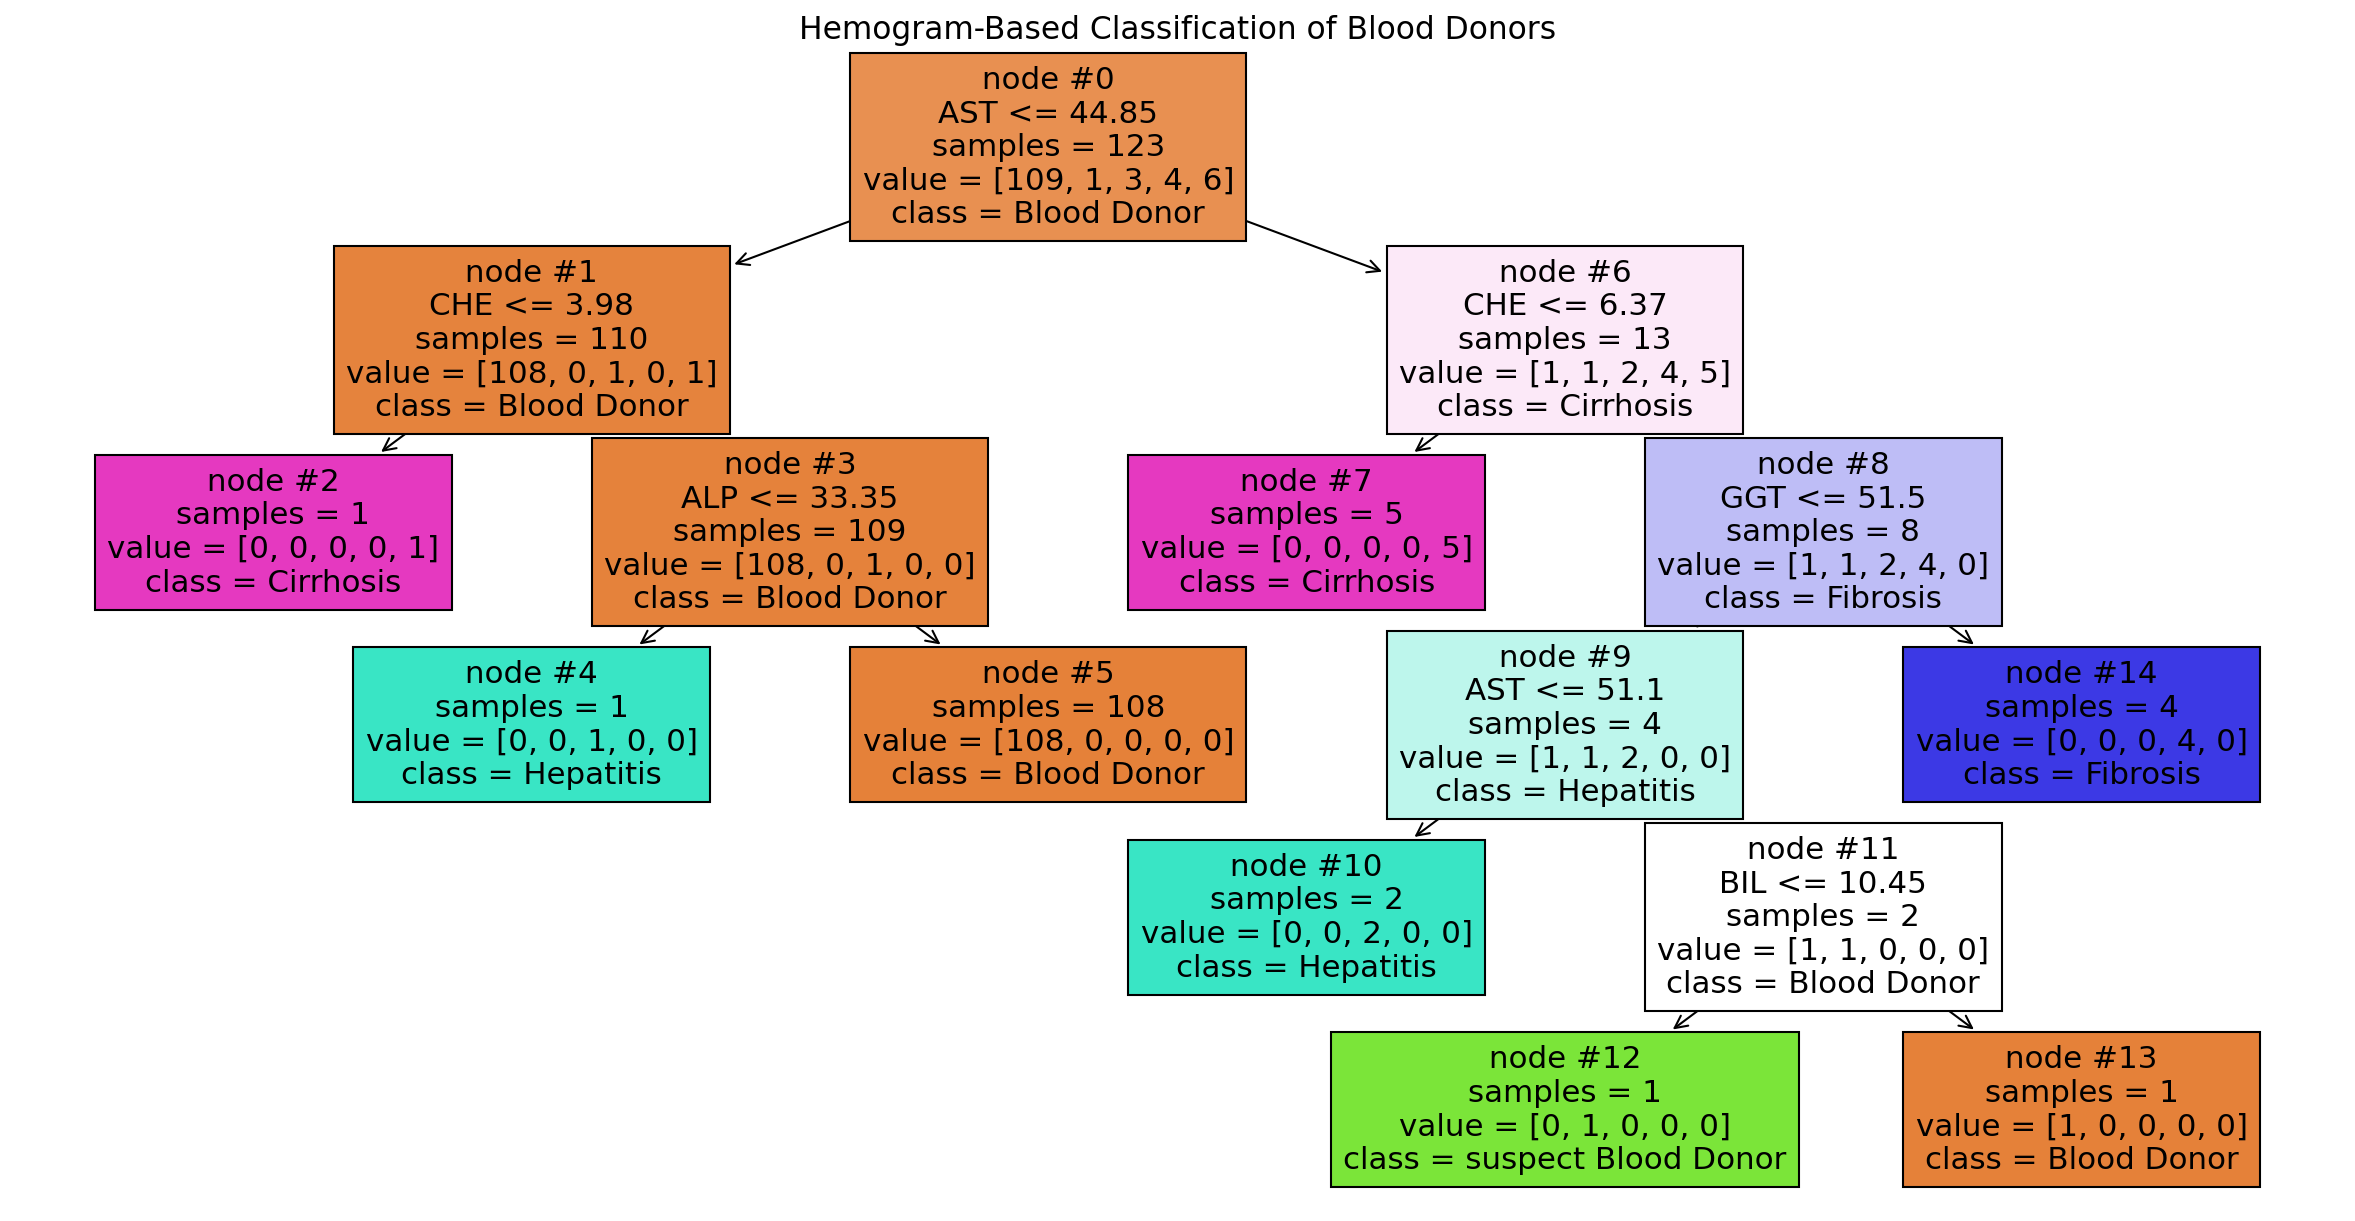

In [21]:
plot_decision_tree(decision_tree=clf, feature_names=list(X.columns), class_names=class_names)

# 5. Pipeline

# Note that warnings are thrown, because our function predicts each patient, so one row at a time, which results in X having no feature name. Due to the fact that we generate a few samples we can guarantee the right oder of the features put into our pipeline 

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd 
import warnings

# read the data
df = pd.read_csv('./data/hcvdat33_Complete.csv', index_col=0) # use first col as index

label_encoder_sex = LabelEncoder()
df['Sex'] = label_encoder_sex.fit_transform(df['Sex'])

X = df.drop(columns=["Category"])
column_order = [col for col in X.columns if col != 'Sex'] + ['Sex']
X = X[column_order]
y = df["Category"]

y_copy = y.copy()

label_encoder_names = LabelEncoder() 
y = label_encoder_names.fit_transform(y)

class_names = label_encoder_names.classes_
class_names = [class_name.split('=')[1] for class_name in class_names]
class_names = list(map(str, class_names)) # convert to list of strings

numerical_columns = ["Age","ALB","ALP","ALT","AST","BIL","CHE","CHOL","CREA","GGT","PROT"]

knn = KNeighborsRegressor(n_neighbors=5)
iterative_imputer = IterativeImputer(estimator=knn, add_indicator=False)
imputer = ColumnTransformer([("imputer", iterative_imputer, numerical_columns)],
                            remainder="passthrough",
                            verbose_feature_names_out=False).set_output(transform="pandas")

class Combiner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dt = DecisionTreeClassifier(max_depth=5)
        self.iso = IsolationForest()
        self.rs = RobustScaler()
        self.pca = PCA(n_components=2)
        self.prepedData = None

    def scale_pca_fit_transform (self,X):
        rs_data= self.rs.fit_transform(X)
        pca_data= self.pca.fit_transform(rs_data)
        return pca_data

    def scale_pca_transform (self, X):
        rs_data= self.rs.transform(X)
        pca_data= self.pca.transform(rs_data)
        return pca_data

    def fit(self, X, y=None):
        self.dt.fit(X, y)
        self.prepedData = self.scale_pca_fit_transform(X)
        index_blood_donor = y_copy[y_copy=="0=Blood Donor"].index

        # Get only data from Blood donors
        blood_donor=self.prepedData.iloc[index_blood_donor,:]
        self.iso.fit(blood_donor)
        

    def transform(self, sample):
        prepedData_iso = self.scale_pca_transform(sample)
        
        plot_decision_tree(self.dt, feature_names=list(sample.columns), class_names=class_names)


        for index in sample.index:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                print("Predicted output for Patient with index:", index)
                row_dt = sample.loc[index,:]
                sample_2d_dt = row_dt.values.reshape(1,-1)
                explain_prediction_dt(self.dt, sample_2d_dt, class_names)
                
                row_iso = prepedData_iso.loc[index,:]
                sample_2d_iso = row_iso.values.reshape(1,-1)
                explain_prediction_iso(self.iso, sample_2d_iso)
        return prepedData_iso
            

pipeline = Pipeline([("imputer", imputer),
                    ('combiner', Combiner())
                    ])

pipeline

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer',
                                                  IterativeImputer(estimator=KNeighborsRegressor()),
                                                  ['Age', 'ALB', 'ALP', 'ALT',
                                                   'AST', 'BIL', 'CHE', 'CHOL',
                                                   'CREA', 'GGT', 'PROT'])],
                                   verbose_feature_names_out=False)),
                ('combiner', Combiner())])

## 6. Test the generated samples

In [23]:
anomalies =generate_anomalies(30)

In [24]:
anomalies

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,31,m,44,167,74,288,16,12,1,41,108,84
1,16,f,27,90,43,108,39,7,5,62,230,12
2,43,f,33,131,133,255,31,13,4,46,91,5
3,33,m,18,86,143,262,26,14,6,29,261,30
4,53,f,57,132,56,118,14,20,11,37,134,44
5,52,m,56,59,23,70,5,16,7,37,284,67
6,68,f,17,125,76,249,27,22,3,34,292,100
7,21,f,72,67,58,159,22,22,12,18,6,45
8,17,m,50,50,106,283,6,4,4,17,131,91
9,46,f,46,65,170,268,8,21,2,70,249,36


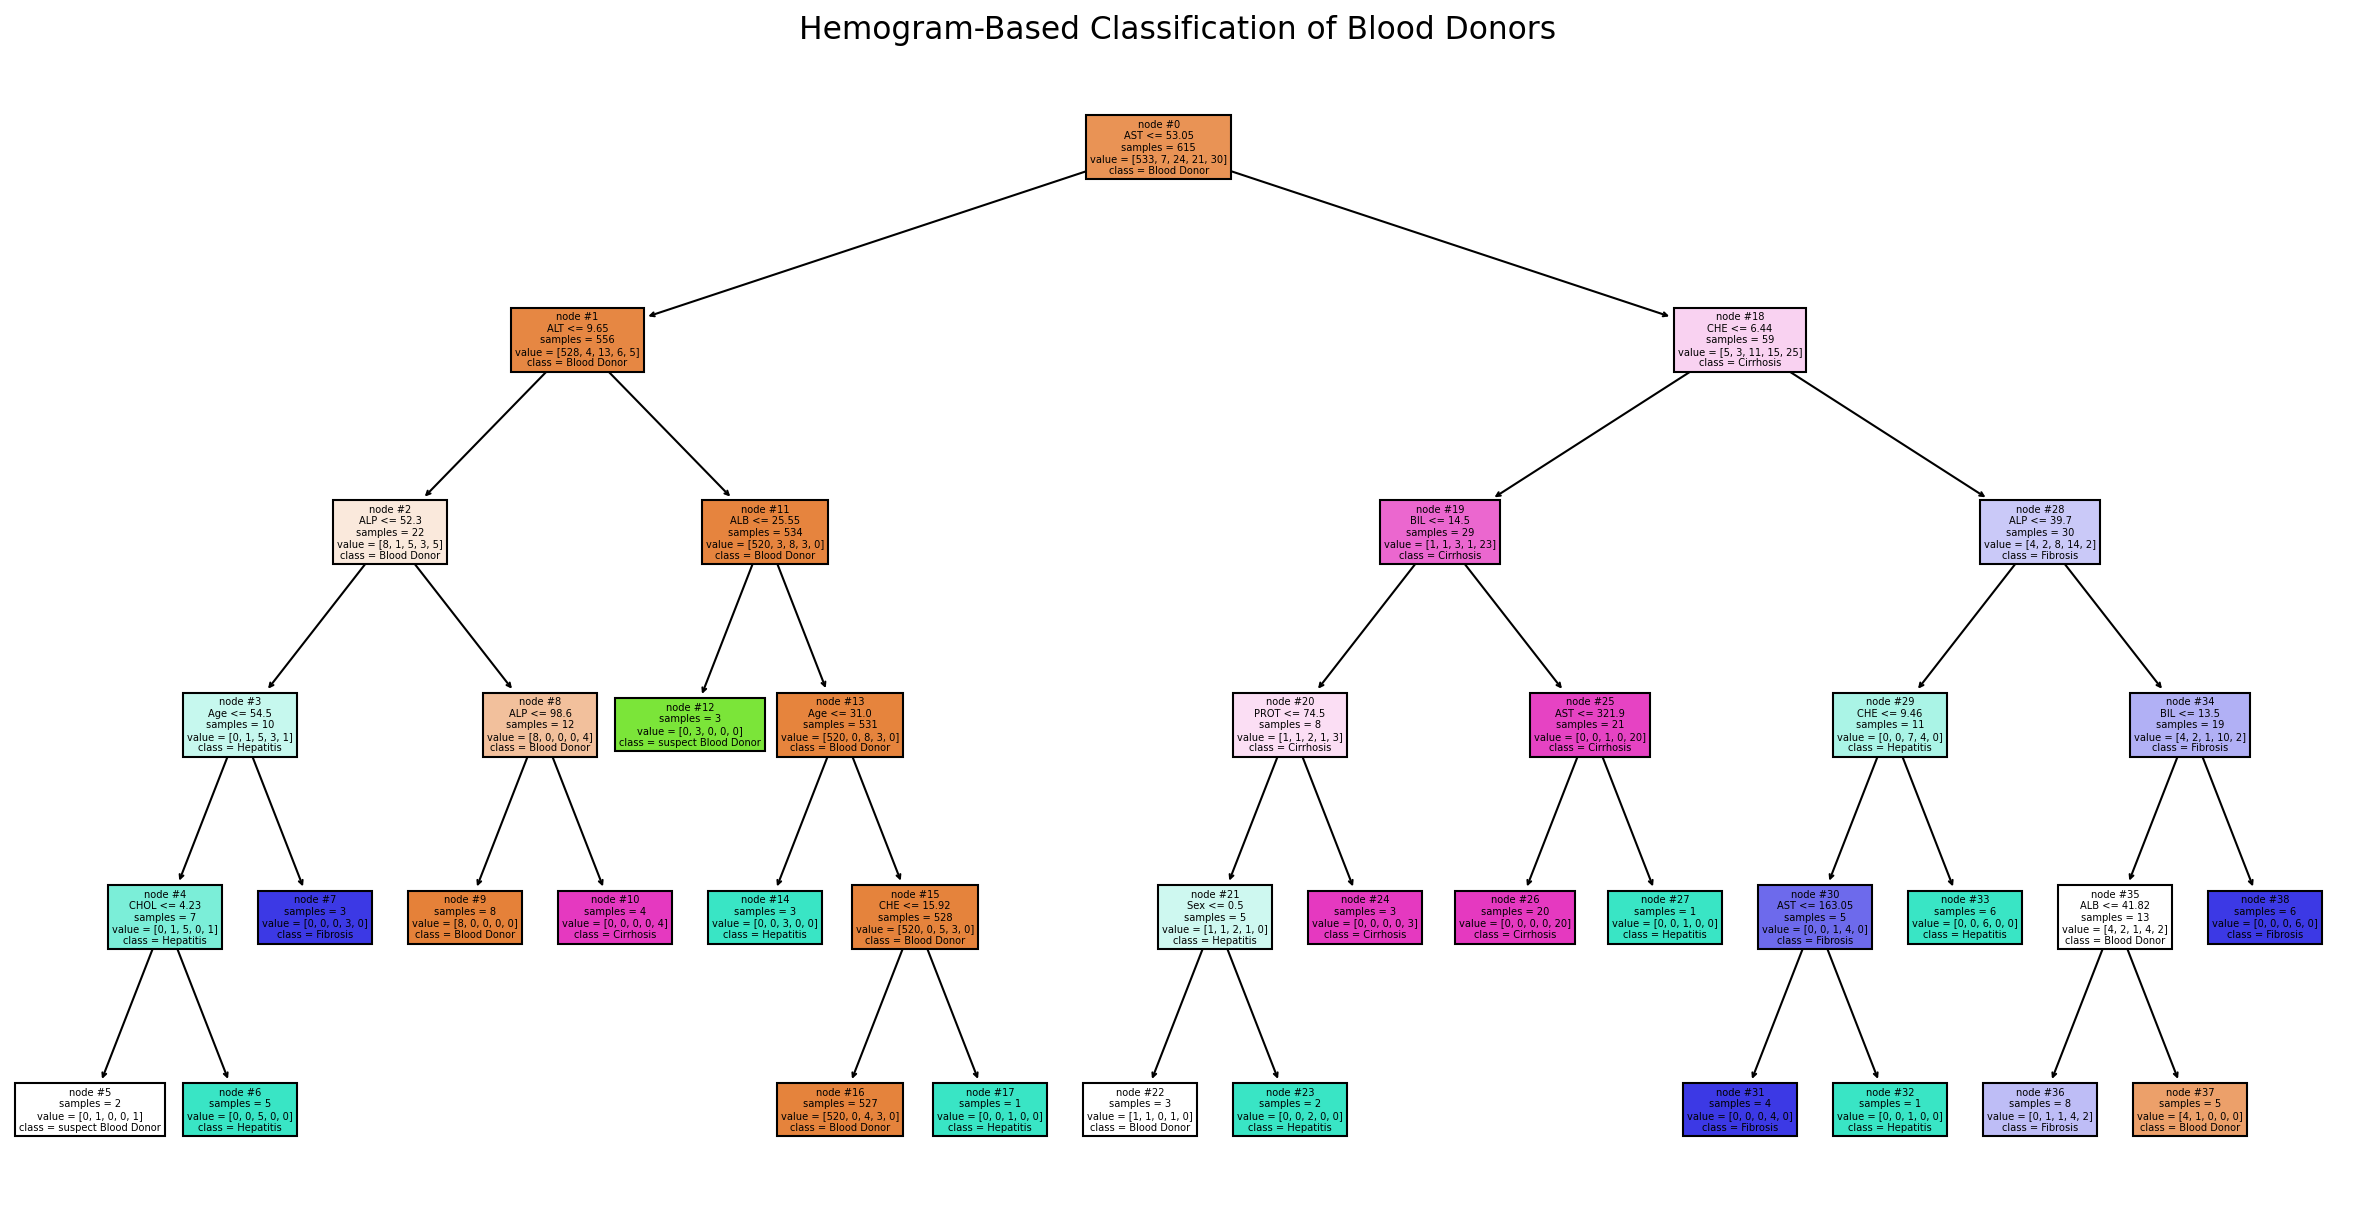

Predicted output for Patient with index: 0
Predicted Class: Fibrosis
Path taken: Nodes 0, 18, 28, 34 and 38
This patient shows an anomaly
Calculated value for the anomaly is: [-0.33812416] 

Predicted output for Patient with index: 1
Predicted Class: Fibrosis
Path taken: Nodes 0, 18, 28, 34 and 38
This patient shows an anomaly
Calculated value for the anomaly is: [-0.2892242] 

Predicted output for Patient with index: 2
Predicted Class: Fibrosis
Path taken: Nodes 0, 18, 28, 34 and 38
This patient shows an anomaly
Calculated value for the anomaly is: [-0.33812416] 

Predicted output for Patient with index: 3
Predicted Class: Fibrosis
Path taken: Nodes 0, 18, 28, 34 and 38
This patient shows an anomaly
Calculated value for the anomaly is: [-0.33812416] 

Predicted output for Patient with index: 4
Predicted Class: Fibrosis
Path taken: Nodes 0, 18, 28, 34 and 38
This patient shows an anomaly
Calculated value for the anomaly is: [-0.2988144] 

Predicted output for Patient with index: 5
Pred

In [25]:
label_encoder_sex = LabelEncoder()
anomalies['Sex'] = label_encoder_sex.fit_transform(anomalies['Sex'])
  
cluster_data_old = pipeline.fit(X,y)
clustering_data_new = pipeline.transform(anomalies) 

In [26]:
preped_data_from_fit = pipeline.named_steps['combiner'].prepedData

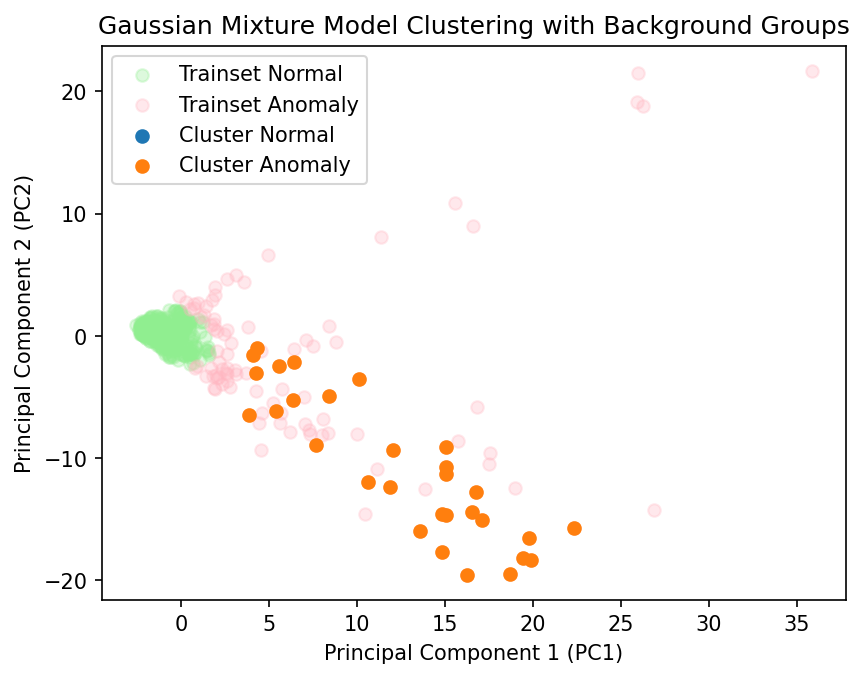

In [27]:
cluster_data = pd.concat([preped_data_from_fit,clustering_data_new], axis=0)

plot_final(cluster_data=cluster_data)

# 6.2 Discussion

As seen in the output we have many predicted classes by the decision tree which are not Blood donors and have a anomaly classified by our isolation forest (27/30 ~ 90%).
We have two cases where our decision tree classifies the patients not as Blood donors but our isolation forest classifies them with having no anomaly (index 2 & 13 ~ 7%).
We also have one cases where our decision tree classifies the patients as Blood donors but our isolation forest classifies them with having anomaly (index 25 ~ 3%).

